<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/stock-price-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-series forecasting: Apple stock prediction


In [119]:
!pip install yfinance --quiet

In [120]:
import yfinance as yf
import pandas as pd
import numpy as np
# getting data from Yahoo Finance
stock_name = 'AAPL'
data = yf.download(stock_name, start="2019-01-01", end="2025-01-01")

[*********************100%***********************]  1 of 1 completed


In [121]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2019-01-02,37.667179,37.889005,36.787037,36.944462,148158800
2019-01-03,33.915257,34.757234,33.869937,34.342207,365248800
2019-01-04,35.363068,35.432241,34.299268,34.473387,234428400
2019-01-07,35.284355,35.499026,34.800159,35.468017,219111200
2019-01-08,35.956989,36.212208,35.425089,35.673149,164101200


In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1510 entries, 2019-01-02 to 2024-12-31
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1510 non-null   float64
 1   (High, AAPL)    1510 non-null   float64
 2   (Low, AAPL)     1510 non-null   float64
 3   (Open, AAPL)    1510 non-null   float64
 4   (Volume, AAPL)  1510 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8 KB


In [123]:
data['close price']=data['Close']
data.index=pd.to_datetime(data.index)


In [124]:
data.drop(columns=['Open','High','Close','Low','Volume'],inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1510 entries, 2019-01-02 to 2024-12-31
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (close price, )  1510 non-null   float64
dtypes: float64(1)
memory usage: 23.6 KB


In [125]:
data.head()

Price,close price
Ticker,
Date,
2019-01-02,37.667179
2019-01-03,33.915257
2019-01-04,35.363068
2019-01-07,35.284355
2019-01-08,35.956989


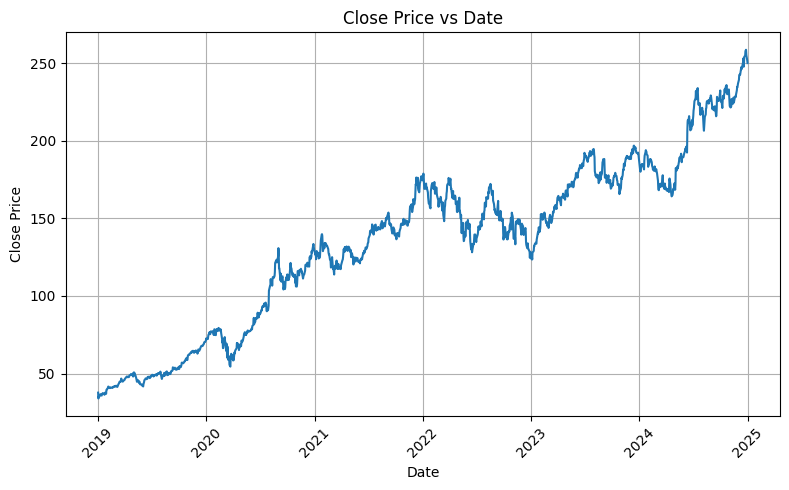

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(data.index, data['close price'])
plt.title('Close Price vs Date')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# creating lag features to be used for DNN and ensemble methods

In [127]:
lags = [1, 7, 30, 365]  # Example: 1-day, 2-day, 5-day, 10-day lags

for lag in lags:
    data[f'Close_lag_{lag}'] = data['close price'].shift(lag)

In [128]:
data = data.dropna()
data.head()

Price,close price,Close_lag_1,Close_lag_7,Close_lag_30,Close_lag_365
Ticker,,,,,
Date,,,,,
2020-06-15,83.461800,82.442207,78.432045,70.151237,37.667179
2020-06-16,85.673729,83.461800,80.665871,71.143791,33.915257
2020-06-17,85.554474,85.673729,81.142815,72.211563,35.363068
2020-06-18,85.588547,85.554474,83.705132,72.956612,35.284355
2020-06-19,85.099449,85.588547,85.858658,73.711327,35.956989


In [129]:
data.tail()

Price,close price,Close_lag_1,Close_lag_7,Close_lag_30,Close_lag_365
Ticker,,,,,
Date,,,,,
2024-12-24,257.916443,254.989655,247.857483,223.983734,189.047287
2024-12-26,258.735504,257.916443,250.764282,223.983734,192.318848
2024-12-27,255.309296,258.735504,253.201599,224.872757,192.061081
2024-12-30,251.923019,255.309296,247.777573,227.969360,193.419296
2024-12-31,250.144974,251.923019,249.515656,224.752884,191.466248


In [130]:
data['date_column']=data.index
data['day'] = data['date_column'].dt.day
data['month'] = data['date_column'].dt.month
data['year'] = data['date_column'].dt.year
data['weekday'] = data['date_column'].dt.day_name()  # Gives full weekday name (e.g., "Thursday")
#data.drop(columns=['date_column'],inplace=True)
data.head()

<ipython-input-130-0559b48440af>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date_column']=data.index
<ipython-input-130-0559b48440af>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day'] = data['date_column'].dt.day
<ipython-input-130-0559b48440af>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Price,close price,Close_lag_1,Close_lag_7,Close_lag_30,Close_lag_365,date_column,day,month,year,weekday
Ticker,,,,,,,,,,
Date,,,,,,,,,,
2020-06-15,83.461800,82.442207,78.432045,70.151237,37.667179,2020-06-15,15,6,2020,Monday
2020-06-16,85.673729,83.461800,80.665871,71.143791,33.915257,2020-06-16,16,6,2020,Tuesday
2020-06-17,85.554474,85.673729,81.142815,72.211563,35.363068,2020-06-17,17,6,2020,Wednesday
2020-06-18,85.588547,85.554474,83.705132,72.956612,35.284355,2020-06-18,18,6,2020,Thursday
2020-06-19,85.099449,85.588547,85.858658,73.711327,35.956989,2020-06-19,19,6,2020,Friday


In [131]:
data.tail()

Price,close price,Close_lag_1,Close_lag_7,Close_lag_30,Close_lag_365,date_column,day,month,year,weekday
Ticker,,,,,,,,,,
Date,,,,,,,,,,
2024-12-24,257.916443,254.989655,247.857483,223.983734,189.047287,2024-12-24,24,12,2024,Tuesday
2024-12-26,258.735504,257.916443,250.764282,223.983734,192.318848,2024-12-26,26,12,2024,Thursday
2024-12-27,255.309296,258.735504,253.201599,224.872757,192.061081,2024-12-27,27,12,2024,Friday
2024-12-30,251.923019,255.309296,247.777573,227.969360,193.419296,2024-12-30,30,12,2024,Monday
2024-12-31,250.144974,251.923019,249.515656,224.752884,191.466248,2024-12-31,31,12,2024,Tuesday


In [132]:
#Cyclic Encoding (Best for LSTMs and Time-Series)
#Best for LSTM models, as it captures the cyclic nature of time-based data.
#Transforms features into sine and cosine to preserve periodicity.
# Convert time-based features into cyclic representation
data['day_sin'] = np.sin(2 * np.pi * data['day'] / 31)
data['day_cos'] = np.cos(2 * np.pi * data['day'] / 31)

data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

data['year_sin'] = np.sin(2 * np.pi * data['year'] / 365)
data['year_cos'] = np.cos(2 * np.pi * data['year'] / 365)
data.drop(columns=['day','month','year'],inplace=True)
data.head()

Price,close price,Close_lag_1,Close_lag_7,Close_lag_30,Close_lag_365,date_column,weekday,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos
Ticker,,,,,,,,,,,,,
Date,,,,,,,,,,,,,
2020-06-15,83.461800,82.442207,78.432045,70.151237,37.667179,2020-06-15,Monday,0.101168,-0.994869,1.224647e-16,-1.0,-0.213521,-0.976938
2020-06-16,85.673729,83.461800,80.665871,71.143791,33.915257,2020-06-16,Tuesday,-0.101168,-0.994869,1.224647e-16,-1.0,-0.213521,-0.976938
2020-06-17,85.554474,85.673729,81.142815,72.211563,35.363068,2020-06-17,Wednesday,-0.299363,-0.954139,1.224647e-16,-1.0,-0.213521,-0.976938
2020-06-18,85.588547,85.554474,83.705132,72.956612,35.284355,2020-06-18,Thursday,-0.485302,-0.874347,1.224647e-16,-1.0,-0.213521,-0.976938
2020-06-19,85.099449,85.588547,85.858658,73.711327,35.956989,2020-06-19,Friday,-0.651372,-0.758758,1.224647e-16,-1.0,-0.213521,-0.976938


In [133]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[['close price',	'Close_lag_1',	'Close_lag_7',	'Close_lag_30',	'Close_lag_365',	'day_sin',	'day_cos', 'month_sin', 'month_cos',	'year_sin',	'year_cos', 'weekday']], data['close price'], test_size=0.2, shuffle=False)
print("Training Dates:", len(X_train))
print("Testing Dates:", len(X_test))
X_train.head()

Training Dates: 916
Testing Dates: 229


Price,close price,Close_lag_1,Close_lag_7,Close_lag_30,Close_lag_365,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,weekday
Ticker,,,,,,,,,,,,
Date,,,,,,,,,,,,
2020-06-15,83.461800,82.442207,78.432045,70.151237,37.667179,0.101168,-0.994869,1.224647e-16,-1.0,-0.213521,-0.976938,Monday
2020-06-16,85.673729,83.461800,80.665871,71.143791,33.915257,-0.101168,-0.994869,1.224647e-16,-1.0,-0.213521,-0.976938,Tuesday
2020-06-17,85.554474,85.673729,81.142815,72.211563,35.363068,-0.299363,-0.954139,1.224647e-16,-1.0,-0.213521,-0.976938,Wednesday
2020-06-18,85.588547,85.554474,83.705132,72.956612,35.284355,-0.485302,-0.874347,1.224647e-16,-1.0,-0.213521,-0.976938,Thursday
2020-06-19,85.099449,85.588547,85.858658,73.711327,35.956989,-0.651372,-0.758758,1.224647e-16,-1.0,-0.213521,-0.976938,Friday


A lag is a time delay or offset in a time series, representing a past value of a variable used to predict its future values.
Example:
If you're forecasting sales, a lag of 1 might mean using last month's sales to predict this month's sales.
Purpose:
Lags help capture the relationships between past and future values of a variable, which can be crucial for accurate forecasting.

ARIMA, SARIMA, and Temporal Fusion Transformer (TFT) Models:

ARIMA (Autoregressive Integrated Moving Average):
A statistical model that uses past values of a time series (autoregressive), differencing to achieve stationarity (integrated), and past forecast errors (moving average) to predict future values.
Strengths: Can handle a wide range of time series patterns, including trends and seasonality.
Limitations: Assumes linear relationships and may struggle with complex patterns.

SARIMA (Seasonal ARIMA):
An extension of ARIMA that incorporates seasonal patterns in the data.
Strengths: Captures both non-seasonal and seasonal patterns in the data.
Limitations: Still assumes linear relationships and may struggle with complex patterns.

Temporal Fusion Transformer (TFT):
A deep learning model that uses self-attention mechanisms to capture complex temporal patterns across multiple time sequences.
Strengths: Can handle complex patterns, multi-horizon forecasting, and interpretability through attention mechanisms.
Limitations: Requires a large amount of data and can be computationally expensive

# LSTM

In [134]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
X_train.loc[:, ['Close_lag_1', 'Close_lag_7', 'Close_lag_30', 'Close_lag_365']] = scaler.fit_transform(
    X_train.loc[:, ['Close_lag_1', 'Close_lag_7', 'Close_lag_30', 'Close_lag_365']]
)

X_test.loc[:, ['Close_lag_1', 'Close_lag_7', 'Close_lag_30', 'Close_lag_365']] = scaler.transform(
    X_test.loc[:, ['Close_lag_1', 'Close_lag_7', 'Close_lag_30', 'Close_lag_365']]
)
X_train = pd.get_dummies(X_train, columns=['weekday'], drop_first=True)  # drop_first to avoid dummy variable trap
X_test = pd.get_dummies(X_test, columns=['weekday'], drop_first=True)

X_train.head()

<ipython-input-134-5ce75a915321>:13: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_train = pd.get_dummies(X_train, columns=['weekday'], drop_first=True)  # drop_first to avoid dummy variable trap
<ipython-input-134-5ce75a915321>:14: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X_test = pd.get_dummies(X_test, columns=['weekday'], drop_first=True)


,"(close price, )","(Close_lag_1, )","(Close_lag_7, )","(Close_lag_30, )","(Close_lag_365, )","(day_sin, )","(day_cos, )","(month_sin, )","(month_cos, )","(year_sin, )","(year_cos, )","('weekday', '')_Monday","('weekday', '')_Thursday","('weekday', '')_Tuesday","('weekday', '')_Wednesday"
Date,,,,,,,,,,,,,,,
2020-06-15,83.461800,0.000000,0.000000,0.000000,0.025882,0.101168,-0.994869,1.224647e-16,-1.0,-0.213521,-0.976938,True,False,False,False
2020-06-16,85.673729,0.008906,0.018852,0.007829,0.000000,-0.101168,-0.994869,1.224647e-16,-1.0,-0.213521,-0.976938,False,False,True,False
2020-06-17,85.554474,0.028226,0.022877,0.016252,0.009987,-0.299363,-0.954139,1.224647e-16,-1.0,-0.213521,-0.976938,False,False,False,True
2020-06-18,85.588547,0.027185,0.044500,0.022129,0.009444,-0.485302,-0.874347,1.224647e-16,-1.0,-0.213521,-0.976938,False,True,False,False
2020-06-19,85.099449,0.027482,0.062674,0.028082,0.014084,-0.651372,-0.758758,1.224647e-16,-1.0,-0.213521,-0.976938,False,False,False,False


In [135]:
X_test.head()

,"(close price, )","(Close_lag_1, )","(Close_lag_7, )","(Close_lag_30, )","(Close_lag_365, )","(day_sin, )","(day_cos, )","(month_sin, )","(month_cos, )","(year_sin, )","(year_cos, )","('weekday', '')_Monday","('weekday', '')_Thursday","('weekday', '')_Tuesday","('weekday', '')_Wednesday"
Date,,,,,,,,,,,,,,,
2024-02-05,186.559906,0.893551,0.966948,0.974282,0.906804,0.848644,0.528964,0.866025,0.5,-0.280231,-0.959933,True,False,False,False
2024-02-06,188.170258,0.909440,0.952268,0.973106,0.904489,0.937752,0.347305,0.866025,0.5,-0.280231,-0.959933,False,False,True,False
2024-02-07,188.279587,0.923506,0.946480,0.964638,0.906531,0.988468,0.151428,0.866025,0.5,-0.280231,-0.959933,False,False,False,True
2024-02-08,187.196121,0.924461,0.915525,0.960325,0.923550,0.998717,-0.050649,0.866025,0.5,-0.280231,-0.959933,False,True,False,False
2024-02-09,187.962463,0.914998,0.884990,0.961110,0.879913,0.968077,-0.250653,0.866025,0.5,-0.280231,-0.959933,False,False,False,False


In [138]:
print(X_train.shape, X_test.shape)

(916, 15) (229, 15)


In [141]:
X_train.shape[0]

916

In [150]:
time_steps = 1
# Calculate how many complete sequences you can create
num_samples = X_train.shape[0] // time_steps
# Reshape the data accordingly
X_train_reshaped = X_train.values[:num_samples * time_steps].reshape((num_samples, time_steps, X_train.shape[1]))
print(X_train_reshaped.shape)

(916, 1, 15)


In [151]:
# Ensure your test data is reshaped similarly to the training data
# Calculate the number of full sequences in the test data
num_samples_test = X_test.shape[0] // time_steps
# Reshape X_test into the same shape as X_train_reshaped
X_test_reshaped = X_test.values[:num_samples_test * time_steps].reshape((num_samples_test, time_steps, X_test.shape[1]))
# Check the new shape of X_test_reshaped
print(X_test_reshaped.shape)

(229, 1, 15)


In [155]:
X_train_reshaped.dtype
# Ensure that your features (X_train_reshaped) are of numeric type
X_train_reshaped = X_train_reshaped.astype('float32')

# Ensure that your target variable (y_train) is of numeric type
y_train = y_train.astype('float32')

# Similarly, apply the same for validation data if needed
X_test_reshaped = X_test_reshaped.astype('float32')
y_test = y_test.astype('float32')

In [159]:
# Define the model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),  # (time_steps, features)
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_reshaped, y_train, epochs=500, batch_size=1000, validation_data=(X_test_reshaped, y_test))


Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 22561.7715 - val_loss: 44178.3047
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 22547.6035 - val_loss: 44160.5469
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 22536.2012 - val_loss: 44143.1367
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 22523.2148 - val_loss: 44126.0508
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 22511.3672 - val_loss: 44109.1758
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 22499.1367 - val_loss: 44092.3984
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 22488.2637 - val_loss: 44075.5781
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 22476.0605 - val_loss: 44058.5859
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 22463.3203 - val_loss: 44041.2539
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 22451.6855 - val_loss: 44023.4414
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 22438.9238 - val_l

In [157]:
# Predict on test data
y_pred = model.predict(X_test)

# Convert predictions back to original scale
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs. predicted prices
plt.figure(figsize=(10,6))
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label="Actual Prices")
plt.plot(df.index[-len(y_pred_actual):], y_pred_actual, label="Predicted Prices")
plt.legend()
plt.title("Stock Price Prediction with LSTM")
plt.show()

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 15), dtype=float32). Expected shape (None, 1, 15), but input has incompatible shape (32, 15)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 15), dtype=float32)
  • training=False
  • mask=None

# facebook Prophet model

In [ ]:
!pip install prophet --quiet

In [ ]:
from prophet import Prophet
model = Prophet()
train, test = train_test_split(data, test_size=0.1, shuffle=False)
print("Training Dates:", len(train))
print("Testing Dates:", len(test))

In [ ]:
df_prophet = train.rename(columns={'date_column': 'ds', 'close price': 'y'})
# Fit the model with the historical data
model.fit(df_prophet)

In [ ]:
# Make future dataframe (predicting for the next 90 days)
future = model.make_future_dataframe(periods=115)

# Predict the future stock prices
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title('Stock Price Prediction using Facebook Prophet')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()